# Flake Detection for TestGrid 


In the continuous integration (CI) project workflow, developers frequently integrate code into a shared repository. Each integration can then be verified by an automated build and tests. Whenever a failure occurs in a test, developers need to manually analyze failures. Failures in the build can be legitimate or due to some other issues like an infrastructure flake, install flake, flaky test, or some other type of failure. SME's can analyze the TestGrid data manually and determine if failures appear to be legitimate or not. However, it takes a lot of human effort and reduces the productivity of a team. In this notebook we will try to reliably detect one of these failure types: Flaky test. 

## What is a flaky test?

A flaky test is one that passes or fails in a nondeterministic way. [See this paper for more details](http://mir.cs.illinois.edu/~eloussi2/publications/fse14.pdf). 

In data science terms, if a test passes and fails in an apparently random sequence then it is likely to be a flake. Tests can also be considered flaky if they pass and fail in a non-random but inconsistent pattern. Therefore, our goal here is to develop a technique for finding apparently random or inconsistent pass/fail sequences, which we can then apply to the TestGrid dataset.       


In [38]:
import os
import sys
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import warnings

import gzip
import json

sns.set()
warnings.filterwarnings("ignore")

In [39]:
# adding path to notebook consisting of modules to be imported
module_path = os.path.abspath(os.path.join("../../data-sources/TestGrid"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [40]:
from ipynb.fs.defs.testgrid_EDA import decode_run_length  # noqa: E402

## Data Access

_In depth details for data access and preprocessing can be found in the [testgrid_EDA notebook](../../data-sources/TestGrid/testgrid_EDA.ipynb)._ 

Here we provide two data access methods: download the latest or use example data. If you would like to download the most recent data for a specific grid, then please set `download_data` to `True` on line #2 below and update `dashboard_name` and `job_name` appropriately. Be warned, the output and results will likely change if the most recent data is used instead of the fixed example data.   

Otherwise, we will use the repo's example dataset `data/raw/testgrid_810.json.gz`

Regardless of the method used, we will be looking at "redhat-openshift-ocp-release-4.6-informing/periodic-ci-openshift-release-master-ocp-4.6-e2e-aws-proxy" as our example throughout. 


In [41]:
## Do you want to use download data or stored data?
download_data = False

dashboard_name = "redhat-openshift-ocp-release-4.6-informing"
job_name = "periodic-ci-openshift-release-master-ocp-4.6-e2e-aws-proxy"

if download_data:
    payload = {"show-stale-tests": job_name, "tab": job_name}
    response = requests.get(
        "https://testgrid.k8s.io/" + dashboard_name + "/table", params=payload
    )
    details = pd.DataFrame(response.json()["tests"]).drop(
        [
            "linked_bugs",
            "messages",
            "user_property",
            "target",
            "original-name",
        ],
        axis=1,
    )
else:
    with gzip.open("../../../data/raw/testgrid_810.json.gz", "rb") as read_file:
        data = json.load(read_file)
    details = data['"' + dashboard_name + '"'][job_name]["grid"]
    details = pd.DataFrame(details)

details.head(10)

,name,statuses
0,Overall,"[{'count': 21, 'value': 12}, {'count': 1, 'val..."
1,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu..."
2,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu..."
3,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu..."
4,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu..."
5,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 1}, {'count': 1, 'value..."
6,[sig-api-machinery][Feature:APIServer][Late] k...,"[{'count': 20, 'value': 0}, {'count': 1, 'valu..."
7,[sig-auth][Feature:SCC][Early] should not have...,"[{'count': 20, 'value': 0}, {'count': 1, 'valu..."
8,[sig-arch] Monitor cluster while tests execute,"[{'count': 20, 'value': 0}, {'count': 20, 'val..."
9,[sig-node] pods should never transition back t...,"[{'count': 20, 'value': 0}, {'count': 18, 'val..."


From the column "statuses" above we can see that the time series data is run length encoded. Let's add a decoded column so we can get the data in an easier to use array format.

In [42]:
# use the decode_run_length function imported from TestGrid_EDA notebook
details["values"] = details["statuses"].apply(decode_run_length)

In [43]:
details.head(10)

,name,statuses,values
0,Overall,"[{'count': 21, 'value': 12}, {'count': 1, 'val...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1..."
1,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 1, 12, 12..."
2,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 1, 12, 12..."
3,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 1, 12, 12..."
4,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 12}, {'count': 1, 'valu...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 0, 12, 12..."
5,operator.Run multi-stage test e2e-aws-proxy - ...,"[{'count': 9, 'value': 1}, {'count': 1, 'value...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ..."
6,[sig-api-machinery][Feature:APIServer][Late] k...,"[{'count': 20, 'value': 0}, {'count': 1, 'valu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,[sig-auth][Feature:SCC][Early] should not have...,"[{'count': 20, 'value': 0}, {'count': 1, 'valu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,[sig-arch] Monitor cluster while tests execute,"[{'count': 20, 'value': 0}, {'count': 20, 'val...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,[sig-node] pods should never transition back t...,"[{'count': 20, 'value': 0}, {'count': 18, 'val...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


TestGrids are made of a set of tests that either pass or fail over time. They are multidimensional time series where the values can take either 0 (not run), 1 (pass), 12 (fail), or 13(flaky). 

Now that we have all our data unrolled, lets plot it. We will use green for pass (1), red for fail (12), white for not run (0) and purple for flaky (13). We will also just plot the first 40 rows to save some space.

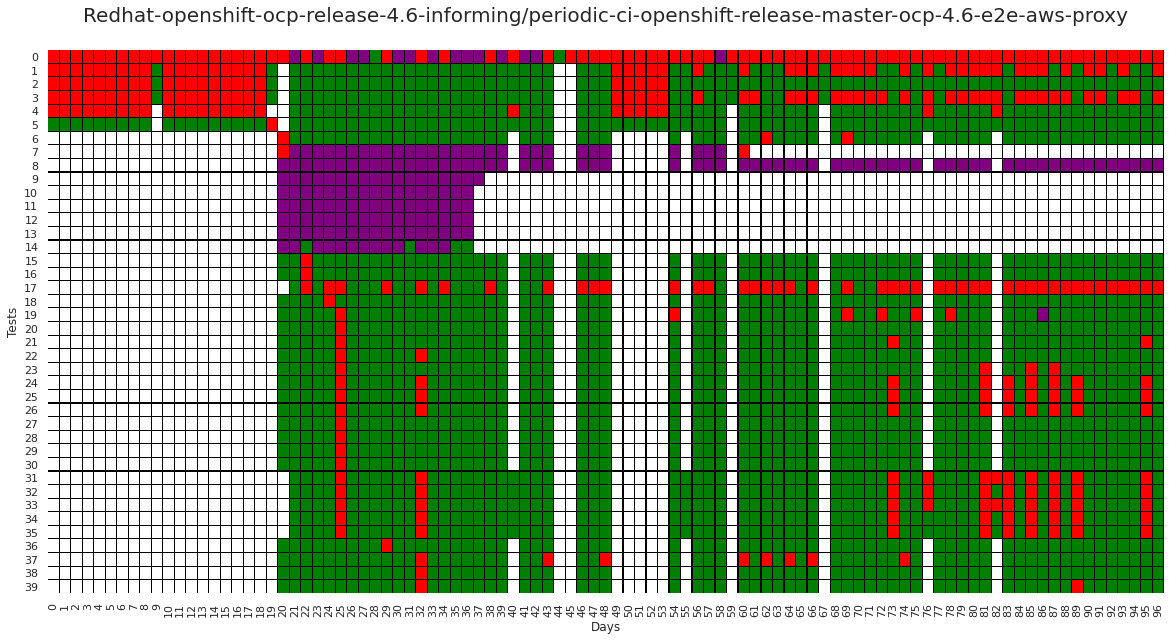

In [44]:
plt.figure(figsize=(20, 10))
cmap = colors.ListedColormap(["white", "green", "red", "purple"])
norm = colors.BoundaryNorm(boundaries=[0, 1, 12, 13], ncolors=3)
sns.heatmap(
    np.array(list(details["values"].values))[:40],
    fmt="",
    cmap=cmap,
    norm=norm,
    cbar=False,
    linewidths=0.1,
    linecolor="Black",
)
plt.ylabel("Tests")
plt.xlabel("Days")
plt.title(
    "Redhat-openshift-ocp-release-4.6-informing/periodic-ci-\
openshift-release-master-ocp-4.6-e2e-aws-proxy\n",
    fontsize=20,
)
plt.show()

Cells with Purple color in the above graph are the existing flake labels defined by the build process. Currently, each failed test is retried, and if it passes on a subsequent run it is considered to be flaky.

We can see from the grid above that there is a large chunk of flakes between test 7 and 15, but there is also a fair amount of irregular pass/failure patterns on the grid that are not being flagged. Let's see if we can create a method to better capture these flakes. 

## Flaky test detection

In the following section, we will explore different methods to detect flaky tests. 

## Naive flakiness method

This method calculates flakiness as a ratio of failed or flaky tests to total tests. The idea being that a score of 50 would mean a 50/50 (random) chance of a pass or fail occurring, indicating a flaky test. The major drawback of this method is that it evaluates the time series as a whole and can't account for specific pass/fail patterns or sub-sequences. If the first half of a series are all pass and the second half are all fail, we would not consider that to be a flake, despite this method flagging it as such.

This is all to say, this is our naive baseline we can use to ensure our later methods are performing well.  

In [45]:
def naive_flake_calc(test_row):
    return (
        100
        * np.logical_or(np.array(test_row) == 12, np.array(test_row) == 13).sum()
        / len(test_row)
    )

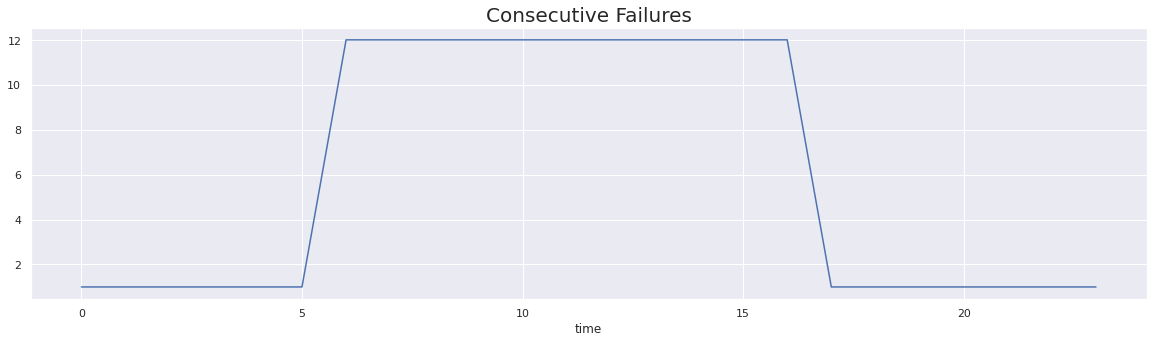

Naive Flake Score 45.833333333333336


In [46]:
test_array = [1] * 6 + [12] * 11 + [1] * 7
plt.figure(figsize=(20, 5))
plt.plot(test_array)
plt.title("Consecutive Failures", fontsize=20)
plt.xlabel("time")
plt.show()
print(f"Naive Flake Score {naive_flake_calc(test_array)}")

In the above cell, we have shown a drawback of the naive flakiness method. As we can see, we have a test array that consist of consecutive test failures, which is not an attribute of a flaky test. However, we got a very high flakiness score.

##  Flip flakiness method

As we discussed earlier, flaky tests pass and fail across multiple runs over a certain period of time. We can characterize this behavior by using the concept of an _edge_. Here we will define an edge as the transition of a particular test case from pass to fail (or fail to pass). Let's look at a couple examples below to illustrate the idea further. 

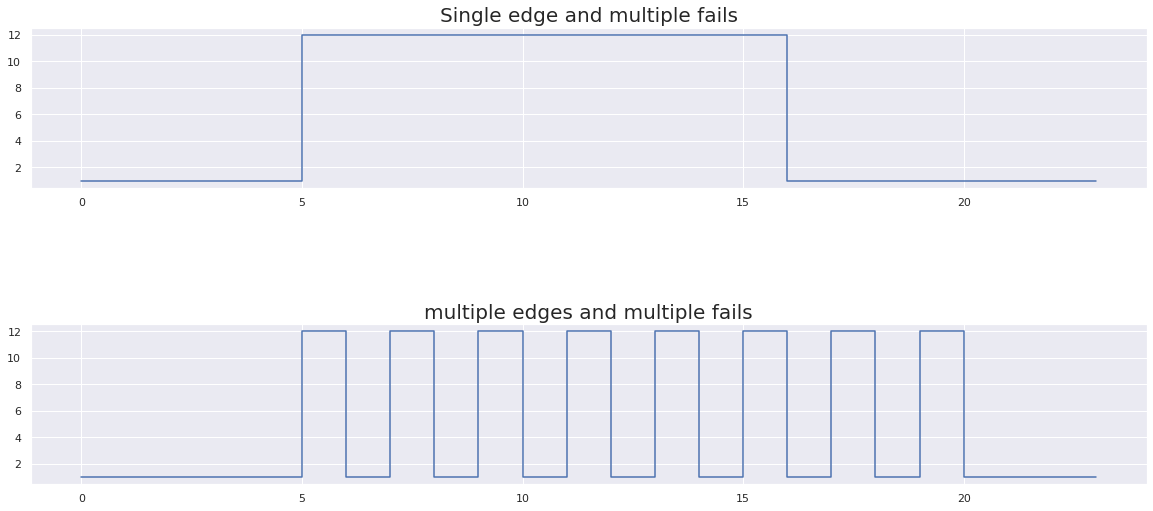

In [47]:
plt.figure(figsize=(20, 10))  # instantiating figure to be 5"x5", 100 dpi resolution


test_array = [1] * 6 + [12] * 11 + [1] * 7
x = np.arange(len(test_array))
plt.subplot(2, 1, 1, aspect=0.3)
plt.step(x, test_array)
plt.title("Single edge and multiple fails", fontsize=20)

plt.subplot(2, 1, 2, aspect=0.3)
test_array_1 = [1] * 5 + [1, 12] * 8 + [1] * 3
plt.step(x, test_array_1)
plt.title("multiple edges and multiple fails", fontsize=20)


plt.show()

In the images above, we have shown example results for 25  test runs. In the first image we can see there are multiple fails but only a single edge. In the second image, we have fewer fails but many more edges. Therefore, the second test exhibits a more erratic behavior pattern, and one we would associate more with a flaky test. 

We calculated the flakiness score as the number of edges divided by total runs. The most common approach to detect flaky test is to run flaky test multiple times and if it passes in any run then it is not considered to be a flaky test ([please see paper for details](http://mir.cs.illinois.edu/~eloussi2/publications/fse14.pdf)). At Google, for example, if a test fails three times in a row, only then is it reported as a real failure; otherwise, it's considered a flake [please see blog for details](https://testing.googleblog.com/2016/05/flaky-tests-at-google-and-how-we.html). We will follow suite and also ignore three or more consecutive failures when calculating a flakiness score.

For the flip flakiness method below the possible scores will lie between 0 and 50; where 0 is no flakiness and 50 is maximum flakiness. 

In [48]:
def calc_consecutive_failures(test_row, i):
    """This function calculates number of consecutive failures

    Parameters
    ----------
    test_row : array
            array of test runs with 0, 1, 12 values as not run, pass, fail respectively
    i : float, int
            index in array i

    Returns
    ----------
    result: int
            number of consecutive failures from index i
    """

    result = 0
    while i < len(test_row) and (test_row[i] == 12 or test_row[i] == 0):
        if test_row[i] == 12:
            result += 1
        i += 1
    return result


def calc_flakiness_score(test_row, ignore_failures_in_a_row=3):
    """This function calculates flakiness score as the number of edges divided by total runs.
    At google, If the test is failing three times in a row, then only it reported as real failures;
    otherwise, it's considered a flaky test.
    (https://testing.googleblog.com/2016/05/flaky-tests-at-google-and-how-we.html)
    Hence, we ignored three or more than three consecutive failures
    and test cases that are not run while calculating the flakiness score.

    We always consider label 13 as an edge.
    since currently, each failed test is retry, and if it's passed on a subsequent run it is considered as flaky.

    Parameters
    ----------
    test_row : array
            array of test runs with 0, 1, 12, 13 values as not run, pass, fail, flaky respectively

    Returns
    ----------
    flakiness: int
            Flakiness score lies between 0 and 100; 0 is no flakiness, and 100 is maximum flakiness.
    """
    flips = 0
    i = 0
    ## ignore not run instances in the starting
    while i < len(test_row) and test_row[i] == 0:
        i += 1

    ## intializing last_passing variable value
    if i >= len(test_row):
        return 0
    elif test_row[i] == 1:
        last_passing = True
    elif test_row[i] == 13:
        last_passing = True
        flips += 1
    elif test_row[i] == 12:
        last_passing = False
    else:
        last_passing = True
    considerd = 1
    i += 1

    while i < len(test_row):
        ## ignoring more than three consecutive failures
        ## If the test is consecutively failing for three or more than three runs,
        ## we considered did not consider it an edge.
        cf = calc_consecutive_failures(test_row, i)
        if cf >= ignore_failures_in_a_row:
            i = i + cf
            if i >= len(test_row):
                break

        s = test_row[i]
        if s == 1:
            ## run is pass
            considerd += 1
            last_passing = True
        elif s == 0:
            ## not run
            pass
        elif s == 13:
            ## flaky
            flips += 1
            considerd += 1
            last_passing = True
        elif s == 12:
            ## run is fail
            considerd += 1
            if last_passing:
                flips += 1
            last_passing = False
        i += 1
    if considerd == 0:
        return 0
    ## multiplying by 2 since flakiness score lies between 0 and 100
    flakiness = (flips / (considerd)) * 100
    return flakiness

Below, we have tested our function using some basic test cases.

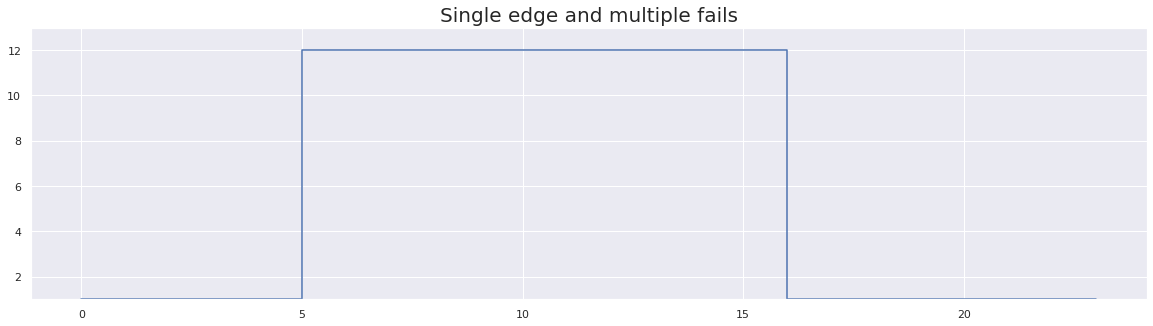

flip-flakiness score:  0.0


In [49]:
plt.figure(figsize=(20, 5))
x = np.arange(len(test_array))
plt.step(x, test_array)
plt.title("Single edge and multiple fails", fontsize=20)
plt.ylim(1, 13)
plt.show()
print(
    "flip-flakiness score: ",
    calc_flakiness_score(test_array),
)

In the above figure, we can see there is only one edge with more than three consecutive failures. Hence we did not consider the above test as a flaky test. Hence, the total flakiness score using the `flip flakiness` method is 0

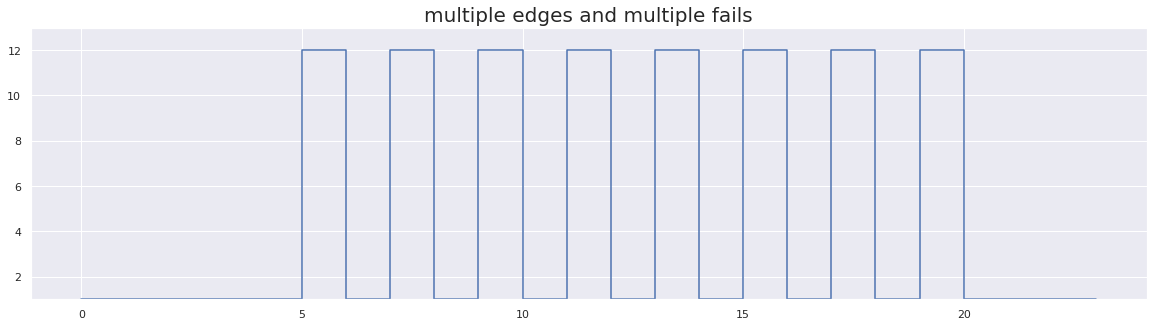

flip-flakiness score:  33.33333333333333


In [50]:
plt.figure(figsize=(20, 5))
x = np.arange(len(test_array_1))
plt.step(x, test_array_1)
plt.ylim(1, 13)
plt.title("multiple edges and multiple fails", fontsize=20)
plt.show()

print(
    "flip-flakiness score: ",
    calc_flakiness_score(test_array_1),
)

In the above figure, we can see there are multiples edges. Hence, this test exhibits a more flake-like behavior pattern. Therefore, our flakiness score is greater. 

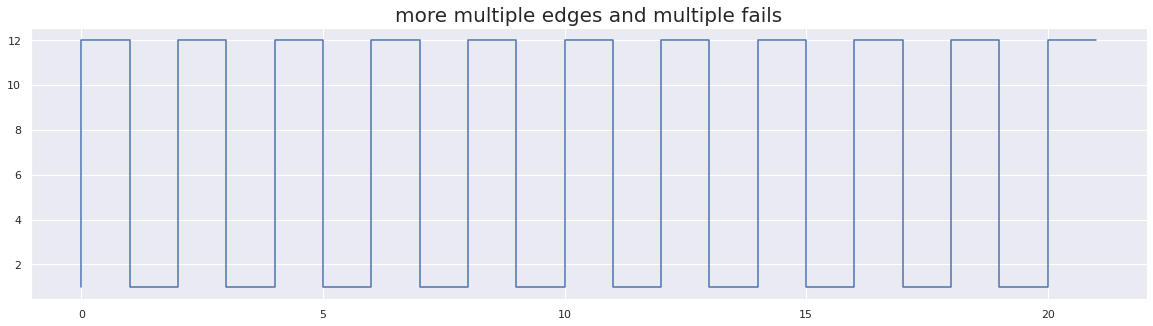

flip-flakiness score:  50.0


In [51]:
plt.figure(figsize=(20, 5))
test_array_7 = [1, 12] * 11
x = np.arange(len(test_array_7))
plt.step(x, test_array_7)
plt.title("more multiple edges and multiple fails", fontsize=20)
plt.show()
print(
    "flip-flakiness score: ",
    calc_flakiness_score(test_array_7),
)

In the above figure, we have simulated an extremely flaky test with an inconsistent pass behavior pattern. And as you can see we get a maximum flakiness score of 50.

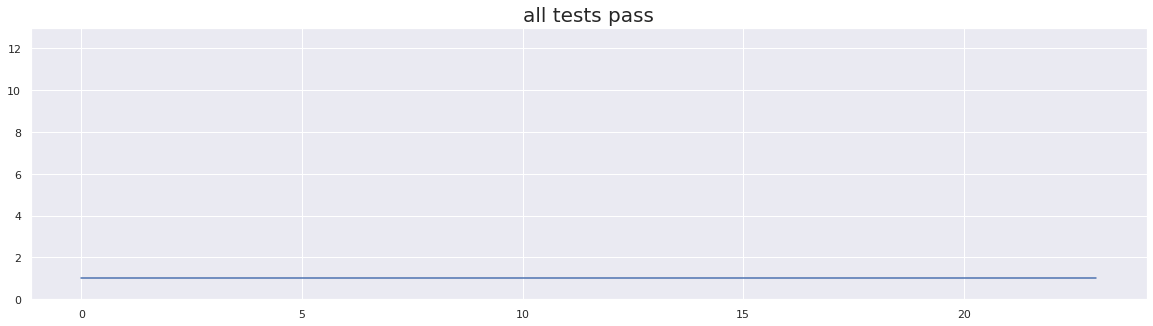

flip-flakiness score:  0.0


In [52]:
plt.figure(figsize=(20, 5))
test_array_2 = [1] * 24
x = np.arange(len(test_array_2))
plt.step(x, test_array_2)
plt.ylim(0, 13)
plt.title("all tests pass", fontsize=20)
plt.show()

print(
    "flip-flakiness score: ",
    calc_flakiness_score(test_array_2),
)

In the above figure, we can see all the test runs passed. And as we would expect, our flakiness score is 0

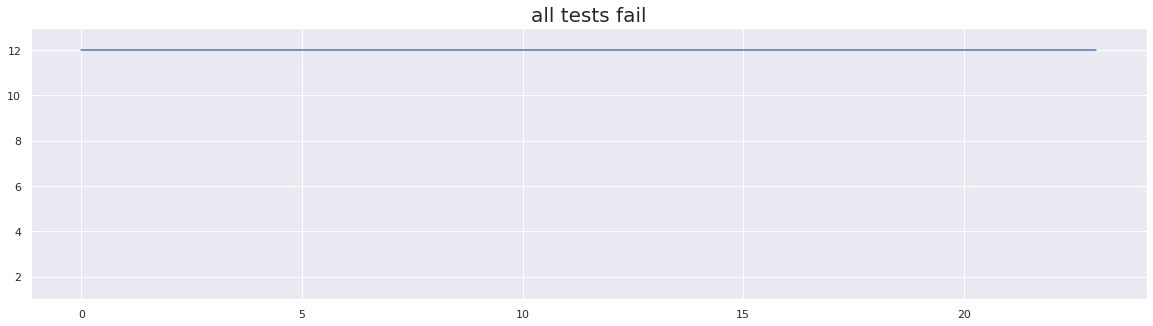

flip-flakiness score:  0.0


In [53]:
plt.figure(figsize=(20, 5))
test_array_3 = [12] * 24
x = np.arange(len(test_array_3))
plt.step(x, test_array_3)
plt.ylim(1, 13)
plt.title("all tests fail", fontsize=20)
plt.show()

print(
    "flip-flakiness score: ",
    calc_flakiness_score(test_array_3),
)

In the above example, we can see that there are no edges and consistent failures occurring for each run. We do not consider this pattern to represent a flake, so the flakiness score using the `flip flakiness` method is 0.

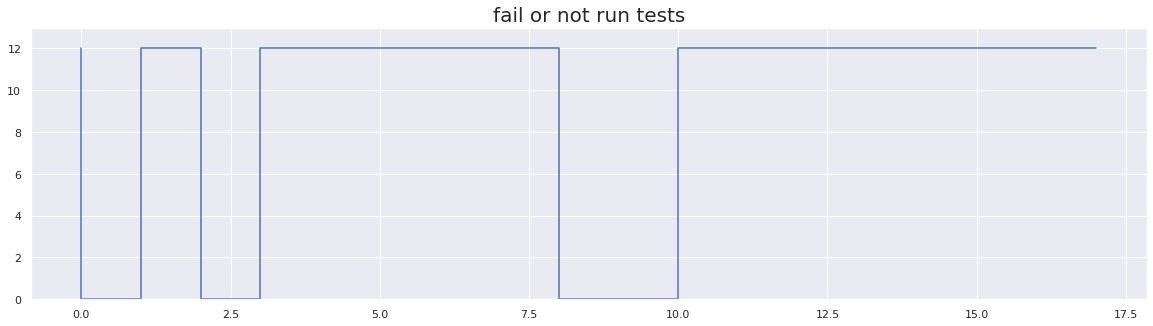

flip-flakiness score:  0.0


In [54]:
plt.figure(figsize=(20, 5))
test_array_4 = [12, 0] * 2 + [12] * 5 + [0] * 2 + [12] * 7
x = np.arange(len(test_array_4))
plt.step(x, test_array_4)
plt.ylim(0, 13)
plt.title("fail or not run tests", fontsize=20)
plt.show()

print(
    "flip-flakiness score: ",
    calc_flakiness_score(test_array_4),
)

In the above example we have simulated consistent failures with irregular non-run instances. As we can see, this method has ignored the not run instances in our calculation of flakiness score.

In addition to the examples above, we have also included the [test cases](https://github.com/GoogleCloudPlatform/testgrid/blob/2a016ff75a27fff1550f5e9f5319cf0114182547/pkg/summarizer/analyzers/flipanalyzer_test.go) used by the TestGrid developers below. 

In [55]:
test_array_google_1 = []
print(
    "Empty list:",
    "Passed" if calc_flakiness_score(test_array_google_1) == 0 else "Failed",
)
test_array_google_2 = [1, 1, 1]
print(
    "All passing:",
    "Passed" if calc_flakiness_score(test_array_google_2) == 0 else "Failed",
)
test_array_google_3 = [1, 12, 1, 1, 13, 1, 1, 1, 1, 12]
print(
    "Multiple flakes:",
    "Passed" if calc_flakiness_score(test_array_google_3) == 30 else "Failed",
)
test_array_google_4 = [1, 12, 12, 1, 1, 1, 1, 12, 1, 1]
print(
    "Short run:",
    "Passed" if calc_flakiness_score(test_array_google_4) == 20 else "Failed",
)
test_array_google_5 = [1, 12, 12, 12, 12, 12, 1, 12, 1, 12]
print(
    "Long run:",
    "Passed" if calc_flakiness_score(test_array_google_5) == 40 else "Failed",
)
test_array_google_6 = [1, 12, 12, 13, 12, 12, 1, 12, 1, 12]
print(
    "Long run interupted by flakes:",
    "Passed" if calc_flakiness_score(test_array_google_6) == 50 else "Failed",
)

Empty list: Passed
All passing: Passed
Multiple flakes: Passed
Short run: Passed
Long run: Passed
Long run interupted by flakes: Passed


Excellent! All tests passed. From our hand-crafted examples and the tests cases above we can conclude that the flip flakiness method we have used here performs at least on par with the methods implemented by TestGrid. 

One drawback of this method you may have noticed is that it evaluates the entire pass/fail time series for each test, and does not account for possible flaky subset within an otherwise stable test. Let's extend this method to find flaky regions (subsets) in our test data.   

## Flip Flakiness with Optimal Distance

One of the downsides of finding a single value for each test case is that there might be two different consecutive time periods for which the test case is behaving flaky, or the number of edges is relatively low compared to total runs. This could lead to a low flakiness score, despite the test is still being flaky. Let's illustrate this statement with an example. 

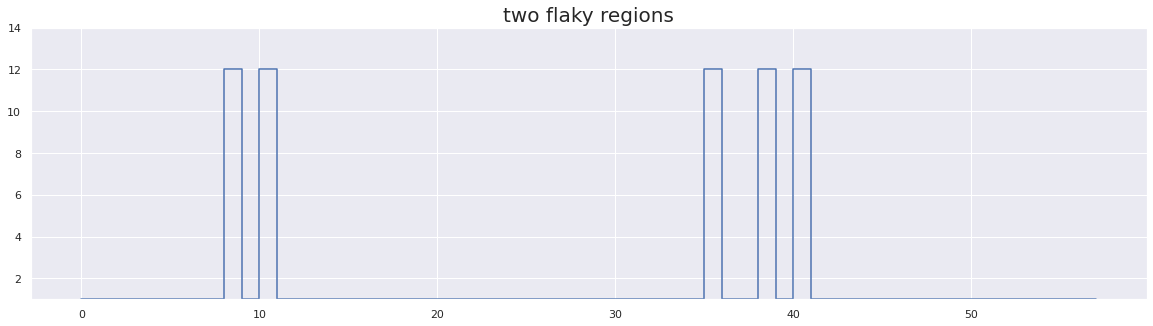

flip-flakiness score:  8.620689655172415


In [56]:
plt.figure(figsize=(20, 5))
test_array_5 = [1] * 8 + [1, 12] * 2 + [1] * 23 + [1, 12, 1, 1, 12, 1, 12] + [1] * 16
x = np.arange(len(test_array_5))
plt.step(x, test_array_5)
plt.ylim(1, 14)
plt.title("two flaky regions", fontsize=20)
plt.show()

print(
    "flip-flakiness score: ",
    calc_flakiness_score(test_array_5),
)

As we can see in the above graph, we have two separate time periods for which behavior is flaky, between runs [8,11] and [35,41]. However, our flakiness score is rather low since the total number of runs is high in comparison. 

To overcome this limitation, instead of calculating the flakiness score on the entire run we will calculate the flakiness score between edges to maximize our flakiness score for flaky subsets of the test. 

Specifically, we calculate the flakiness score between the two farthest edges, which have a flakiness score greater than a user defined threshold. Currently, we use a threshold of flakiness score of 30, but this can tuned according to needs of an application. 

In [57]:
def calc_flake_edges(test_array):
    """This function calculates the number of edges, the transition of a
    particular test case from pass to fail.

    Parameters
    ----------
    test_array : numpy array
            array of test runs with 0, 1, 12, 13 values as not run, pass, fail, flaky respectively

    Returns
    ----------
    flake_edges: numpy array
                        array where the value are the starting of the edge

    """
    flake_edges = []  ## array to store edges
    ignore_failures_in_a_row = 3
    i = 0
    valid = 0
    while i < len(test_array) and test_array[i] == 0:
        i += 1
    ## intializing last_passing variable value
    if i >= len(test_array):
        return 0
    elif test_array[i] == 1:
        last_passing = True
        valid = i
    elif test_array[i] == 13:
        last_passing = True
    elif test_array[i] == 12:
        last_passing = False
    else:
        last_passing = True
    i += 1

    ## Finding all the edges in our test runs
    while i < len(test_array):
        ## ignoring more than three consecutive failures
        ## If the test is consecutively failing for three or more than three runs,
        ## we do not consider it an edge.
        cf = calc_consecutive_failures(test_array, i)
        if cf >= ignore_failures_in_a_row:
            i = i + cf
            if i >= len(test_array):
                break

        s = test_array[i]
        if s == 1:
            ## run is pass
            last_passing = True
            valid = i
        elif s == 0:
            ## not run
            pass
        elif s == 13:
            last_passing = True
            flake_edges.append(i)
        elif s == 12:
            ## run is fail
            if last_passing:
                flake_edges.append(valid)
            last_passing = False
        i = i + 1
    return flake_edges


def flake_edge_end(test_array, flake_edges, index):
    """This function calculates the end of the edges. Starting of the edge will always be 1 or 13

    Parameters
    ----------
    test_array : numpy array
            array of test runs with 0, 1, 12, 13 values as not run, pass, fail, flaky respectively

    Returns
    ----------
    flake_edges: numpy array
                        array where the value are the starting of the edge

    """
    flake_end = flake_edges[index]
    while test_array[flake_end] != 12 and test_array[flake_end] != 13:
        flake_end = flake_end + 1
        if flake_end > len(test_array):
            break
    return flake_end


def calc_optimal_flakiness_score(test_array, threshold=30):
    """Calculate the flakiness score between edges since it will maximize the flakiness score.
    Specifically, we calculate the flakiness score between the two farthest edges
    which have a flakiness score greater than a threshold.

    Parameters
    ----------
    test_array : array
            array of test runs with 0, 1, 12, 13 values as not run, pass, fail, flaky respectively
    threshold: int default 30

    Returns
    ----------
    modified_test_array: numpy array
                        modified test grid where the value of failure due to flake is 13
    flake_edges_dict: dictionary
            key of the dictionary is a tuple of time period, and value is the flakiness score between the time period
    """
    modified_test_array = test_array.copy()
    flake_edges_dict = {}
    flake_edges = calc_flake_edges(test_array)
    ## flakiness score between the two farthest edges
    p = 0
    q = 0
    while p < len(flake_edges):
        possible_flake = False
        for q in range(p + 1, len(flake_edges)):
            flake_end = flake_edge_end(test_array, flake_edges, q)
            curr_flake = calc_flakiness_score(
                test_array[flake_edges[p] : flake_end + 1]
            )
            if curr_flake > threshold:
                possible_flake = True
                max_flake = curr_flake
                max_p = flake_edges[p]
                max_q = flake_end
            else:
                break
        p = q
        if possible_flake:
            for k in range(max_p, flake_end + 1):
                if modified_test_array[k] == 12:
                    modified_test_array[k] = 13
                    curr = k + 1
                    while curr < len(modified_test_array):
                        if modified_test_array[curr] == 12:
                            modified_test_array[curr] = 13
                        else:
                            break
            arr = []
            arr.append(max_p)
            arr.append(max_q)
            flake_edges_dict[tuple(arr)] = max_flake
        if p == len(flake_edges) - 1:
            break
    return modified_test_array, flake_edges_dict

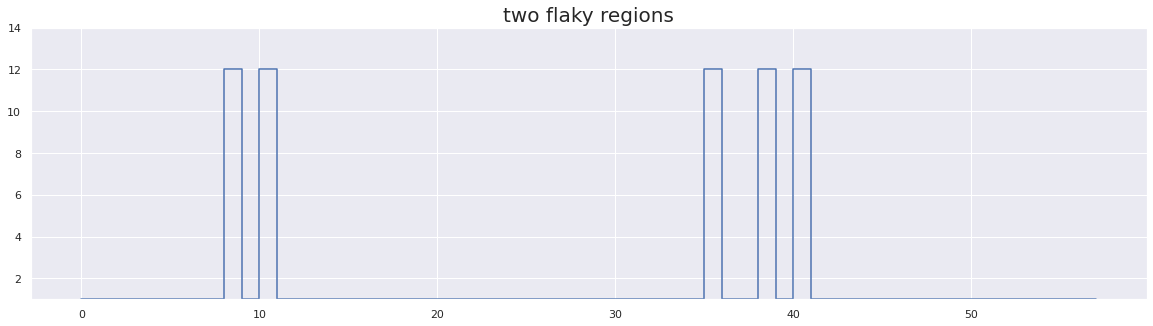

Flip Flakiness with Optimal Distance results: 
 flake between (8, 11) with score of 50.0
 flake between (35, 41) with score of 42.857142857142854


In [58]:
plt.figure(figsize=(20, 5))
x = np.arange(len(test_array_5))
plt.step(x, test_array_5)
plt.ylim(1, 14)
plt.title("two flaky regions", fontsize=20)
plt.show()

modified_test_array, flake_dict = calc_optimal_flakiness_score(test_array_5)
print(
    "Flip Flakiness with Optimal Distance results: ",
)
for i in flake_dict.keys():
    print(f" flake between {i} with score of {flake_dict[i]}")

As we can see in the graph above, we have two separate time periods for which behavior is flaky, between runs [8,11] and [35,41]. Using `flip flakiness with optimal distance` we have a successfully identified these two flaky regions. 

## Comparison of different methods

Now that we have explored 3 different methods for identifying flakes in TestGrid data, lets compare them directly and make sure we move forward with the best method. 

### Comparison of custom test cases
Below we use our custom test cases to compare performance.

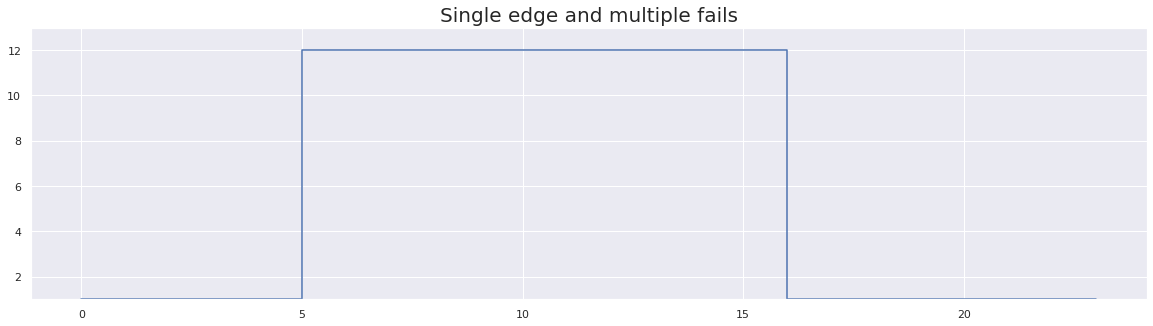

Naive Score:  45.833333333333336  Number of Flaky Tests Detected:  11
Flip-Flakiness Score:  0.0  Number of Flaky Tests Detected:  0
Flip Flakiness with Optimal Distance score:  {}  Number of Flaky Tests Detected:  0


In [59]:
def flake_annotation(val_array, flake_score, flake_score_threshold):
    # for illustration purposes, we are removing the flaky labels
    val_array = [12 if (x == 13) else x for x in val_array]
    if flake_score > flake_score_threshold:
        return [13 if (x == 12) else x for x in val_array]
    else:
        return val_array


plt.figure(figsize=(20, 5))
x = np.arange(len(test_array))
plt.step(x, test_array)
plt.title("Single edge and multiple fails", fontsize=20)
plt.ylim(1, 13)
plt.show()

naive_score = naive_flake_calc(test_array)
total_error_naive = flake_annotation(test_array, naive_score, 10).count(13)
flip_score = calc_flakiness_score(test_array)
total_error_flip = flake_annotation(test_array, flip_score, 10).count(13)
modified_test_array, flake_dict = calc_optimal_flakiness_score(test_array, 30)
total_error_optimal_flip = modified_test_array.count(13)

print(
    "Naive Score: ",
    naive_score,
    " Number of Flaky Tests Detected: ",
    total_error_naive,
)
print(
    "Flip-Flakiness Score: ",
    flip_score,
    " Number of Flaky Tests Detected: ",
    total_error_flip,
)
print(
    "Flip Flakiness with Optimal Distance score: ",
    flake_dict,
    " Number of Flaky Tests Detected: ",
    total_error_optimal_flip,
)

Given the above example, which we do not consider to be a flake, we can see that both `Flip-Flakiness with optimal distance` and `Flip-Flakiness` performed equally well, whereas the `Naive` method incorrectly flagged this example as flaky. 

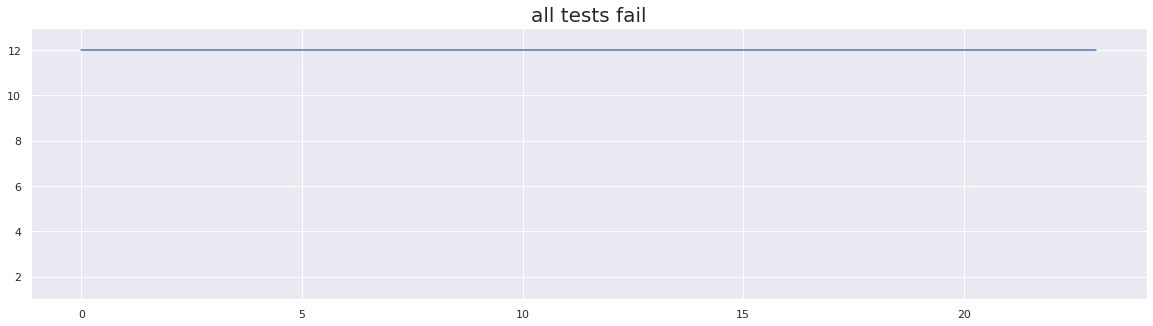

Naive Score:  100.0  Number of Flaky Tests Detected:  24
Flip-Flakiness Score:  0.0  Number of Flaky Tests Detected:  0
Flip Flakiness with Optimal Distance score:  {}  Number of Flaky Tests Detected:  0


In [60]:
plt.figure(figsize=(20, 5))
x = np.arange(len(test_array_3))
plt.step(x, test_array_3)
plt.ylim(1, 13)
plt.title("all tests fail", fontsize=20)
plt.show()

naive_score = naive_flake_calc(test_array_3)
total_error_naive = flake_annotation(test_array_3, naive_score, 10).count(13)
flip_score = calc_flakiness_score(test_array_3)
total_error_flip = flake_annotation(test_array_3, flip_score, 10).count(13)
modified_test_array, flake_dict = calc_optimal_flakiness_score(test_array_3, 30)
total_error_optimal_flip = modified_test_array.count(13)

print(
    "Naive Score: ",
    naive_score,
    " Number of Flaky Tests Detected: ",
    total_error_naive,
)
print(
    "Flip-Flakiness Score: ",
    flip_score,
    " Number of Flaky Tests Detected: ",
    total_error_flip,
)
print(
    "Flip Flakiness with Optimal Distance score: ",
    flake_dict,
    " Number of Flaky Tests Detected: ",
    total_error_optimal_flip,
)

Again, we do not consider the above  example to be a flake as it shows consistent failing behavior. And as expected, both `Flip-Flakiness with optimal distance` and `Flip-Flakiness` performed equally well again, whereas the `Naive` method incorrectly flagged this example as flaky. 

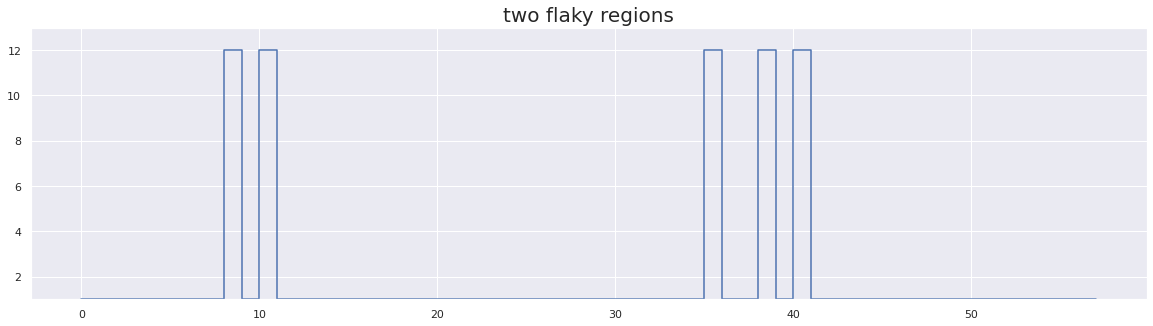

Naive Score:  8.620689655172415  Number of Flaky Tests Detected:  0
Flip-Flakiness Score:  8.620689655172415  Number of Flaky Tests Detected:  0
Flip Flakiness with Optimal Distance score:  {(8, 11): 50.0, (35, 41): 42.857142857142854} 
	Number of Flaky Tests Detected:  5


In [61]:
plt.figure(figsize=(20, 5))
x = np.arange(len(test_array_5))
plt.step(x, test_array_5)
plt.ylim(1, 13)
plt.title("two flaky regions", fontsize=20)
plt.show()

naive_score = naive_flake_calc(test_array_5)
total_error_naive = flake_annotation(test_array_5, naive_score, 10).count(13)
flip_score = calc_flakiness_score(test_array_5)
total_error_flip = flake_annotation(test_array_5, flip_score, 10).count(13)
modified_test_array, flake_dict = calc_optimal_flakiness_score(test_array_5, 30)
total_error_optimal_flip = modified_test_array.count(13)

print(
    "Naive Score: ",
    naive_score,
    " Number of Flaky Tests Detected: ",
    total_error_naive,
)
print(
    "Flip-Flakiness Score: ",
    flip_score,
    " Number of Flaky Tests Detected: ",
    total_error_flip,
)
print(
    "Flip Flakiness with Optimal Distance score: ",
    flake_dict,
    "\n\tNumber of Flaky Tests Detected: ",
    total_error_optimal_flip,
)

As we can see in the above example, we have two separate time periods for which behavior is flaky, between runs [8,7] and [31,37]. However, our flakiness score using `flip-flakiness` and `naive flakiness` method is rather low since the total number of runs is high compared to the number of edges and both methods performed poorly at detecting flaky tests. 

However, `Flip Flakiness with Optimal Distance` method is able to  correctly detect the flaky test regions.

Given the results of the above tests, it is safe to conclude that `Flip Flakiness with Optimal Distance` is the best method to identify flakes moving forward. However, that is only based on these handcrafted test examples. Now lets look at some read testgrid data and see how each method performs. 

## Comparison of TestGrids

We will now apply each method to real testgrid data and see how well each performs.


### Original TestGrid

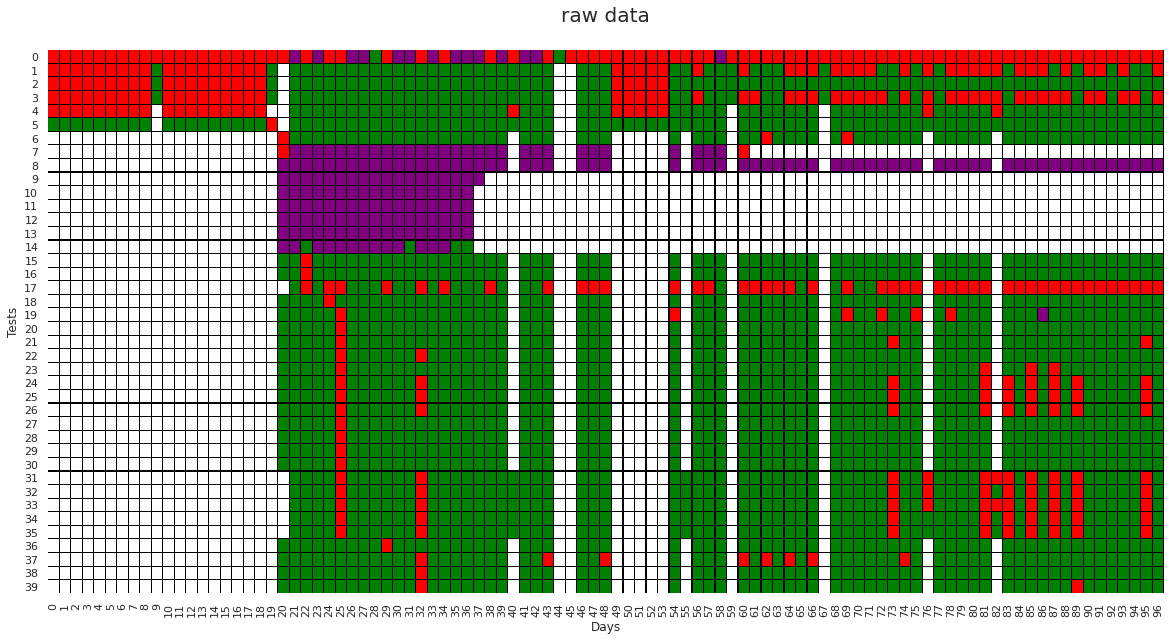

In [62]:
plt.figure(figsize=(20, 10))
cmap = colors.ListedColormap(["white", "green", "red", "purple"])
norm = colors.BoundaryNorm(boundaries=[0, 1, 12, 13], ncolors=3)
sns.heatmap(
    np.array(list(details["values"][:40].values)),
    fmt="",
    cmap=cmap,
    norm=norm,
    cbar=False,
    linewidths=0.1,
    linecolor="Black",
)
plt.ylabel("Tests")
plt.xlabel("Days")
plt.title("raw data\n", fontsize=20)
plt.show()

Cells with Purple color in the above graph are the existing flake labels for individual test runs provided by the underlying CI system. 

In [63]:
total_existing_flake_label = np.count_nonzero(
    np.array(list(details["values"][:40].values)) == 13
)
print(
    "total number of flakes labeled by the ci system's algorithm:",
    total_existing_flake_label,
)

total number of flakes labeled by the ci system's algorithm: 207


### Naive flake method

Below we are annotating a testgrid using the naive flake detection method. 

In [64]:
flake_score_threshold = 30
# calculate the flakiness score by naive method for each test in our dataset.
details["naive_flakiness_score"] = details["values"].apply(
    lambda x: naive_flake_calc(x)
)
details["naive_flakiness"] = details.apply(
    lambda x: flake_annotation(
        x["values"], x["naive_flakiness_score"], flake_score_threshold
    ),
    axis=1,
)

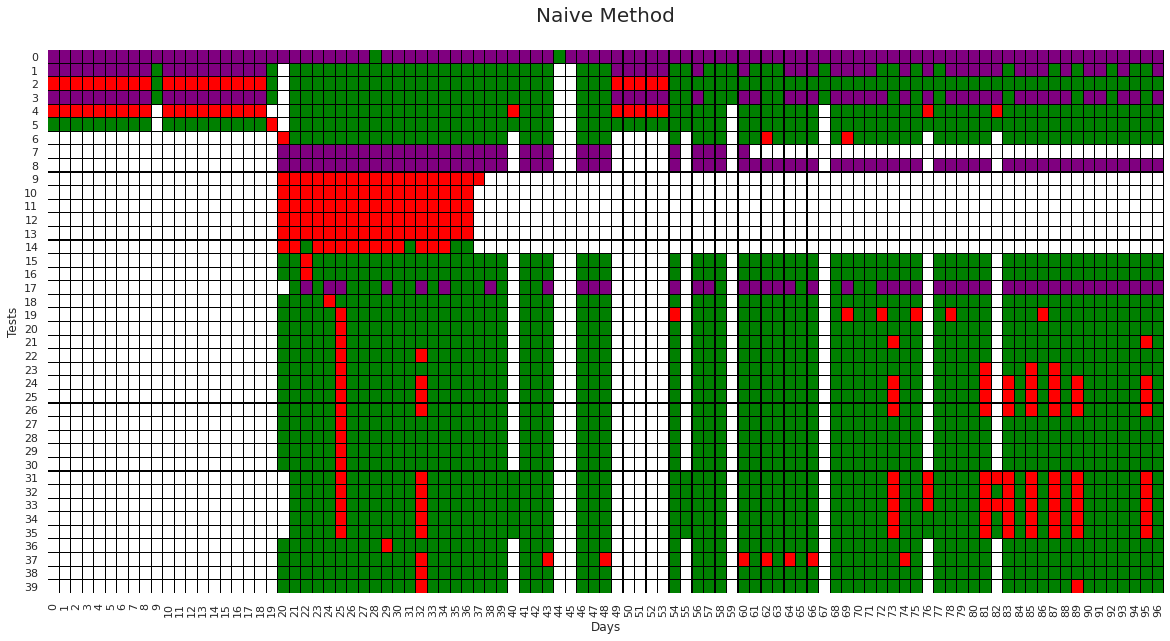

In [65]:
plt.figure(figsize=(20, 10))
cmap = colors.ListedColormap(["white", "green", "red", "purple"])
norm = colors.BoundaryNorm(boundaries=[0, 1, 12, 13], ncolors=3)
sns.heatmap(
    np.array(list(details["naive_flakiness"][:40].values)),
    fmt="",
    cmap=cmap,
    norm=norm,
    cbar=False,
    linewidths=0.1,
    linecolor="Black",
)
plt.ylabel("Tests")
plt.xlabel("Days")
plt.title("Naive Method\n", fontsize=20)
plt.show()

Cells with Purple color in the above graph are the labels given by the naive flake algorithm. We can see the `naive flake algorithm` is unable to detect many flaky tests such as test number 19, 22, 23, 24, 25, 34, 35, 37. Also, for tests 1, 3 from the time-stamp 0 to 18 consistent failures are occurring, which is not a flake behavior but this method still incorrectly identifies them as flaky. 

In [66]:
total_naive_flake_label = np.count_nonzero(
    np.array(list(details["naive_flakiness"][:40].values)) == 13
)
print(
    "Number of flake labels given by the naive flakiness method: ",
    total_naive_flake_label,
)
print(
    "Total flaky tests detected by the `naive flakiness method` is",
    round(total_naive_flake_label / total_existing_flake_label, 2),
    "times \nthe total flaky test detected by the existing testgrid method ",
)

Number of flake labels given by the naive flakiness method:  332
Total flaky tests detected by the `naive flakiness method` is 1.6 times 
the total flaky test detected by the existing testgrid method 


### Flip flake method 
Below we are annotating testgrid using the flip flake detection method.

In [67]:
flake_score_threshold = 30
## calculate the flakiness score by flip method for each test in our dataset.
details["flip_flakiness_score"] = details["values"].apply(
    lambda x: calc_flakiness_score(x)
)
details["flip_flakiness"] = details.apply(
    lambda x: flake_annotation(
        x["values"], x["flip_flakiness_score"], flake_score_threshold
    ),
    axis=1,
)

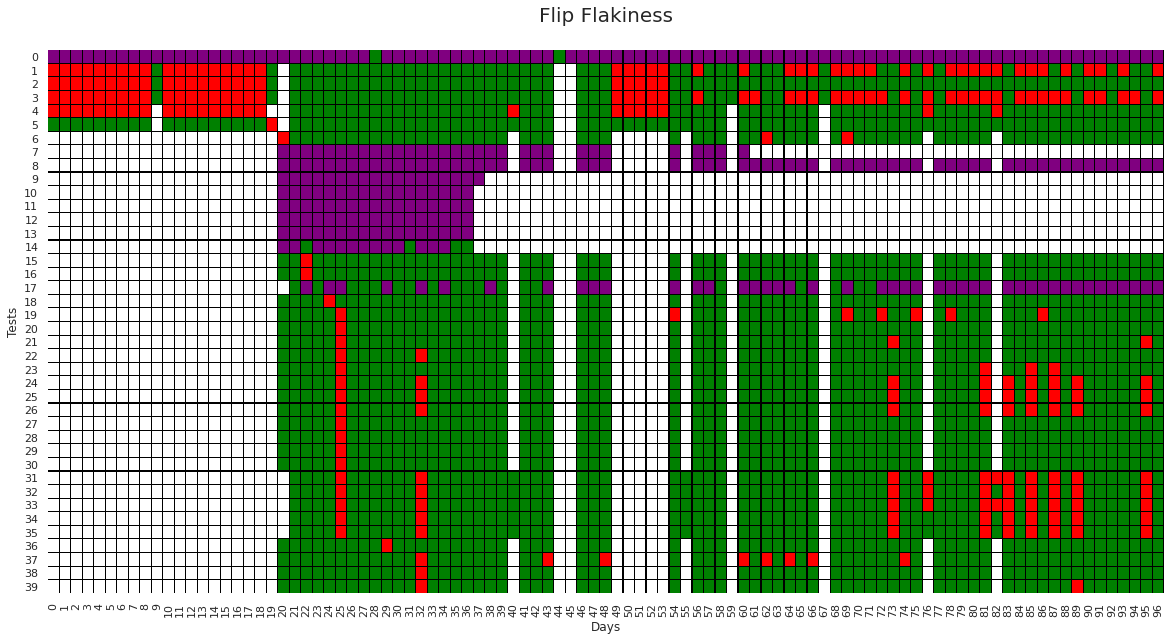

In [68]:
plt.figure(figsize=(20, 10))
cmap = colors.ListedColormap(["white", "green", "red", "purple"])
norm = colors.BoundaryNorm(boundaries=[0, 1, 12, 13], ncolors=3)
sns.heatmap(
    np.array(list(details["flip_flakiness"][:40].values)),
    fmt="",
    cmap=cmap,
    norm=norm,
    cbar=False,
    linewidths=0.1,
    linecolor="Black",
)
plt.ylabel("Tests")
plt.xlabel("Days")
plt.title("Flip Flakiness\n", fontsize=20)
plt.show()

Cells with Purple color in the above graph are the labels given by the `flip flake algorithm`. Though it performed better than `naive flake algorithm`, but it was still unable to detect flaky behaviors for test number 23 and 24 due to a low occurrence of failures in those tests. Also, for tests 1,2,3,4 from the time-stamp 0 to 18 and for test 17 for time-stamp 74 to 96 consistent failures are occurring, which not a behavior of flaky test but still incorrectly detected as flaky.

In [69]:
total_flip_flake_label = np.count_nonzero(
    np.array(list(details["flip_flakiness"][:40].values)) == 13
)
print(
    "Number of flake labels given by the `flip flakiness` method:",
    total_flip_flake_label,
)
print(
    "Total flaky test detected by the `flip flake` method is",
    round(total_flip_flake_label / total_existing_flake_label, 2),
    "times \nthe total flaky tests detected by the existing testgrid method ",
)

Number of flake labels given by the `flip flakiness` method: 333
Total flaky test detected by the `flip flake` method is 1.61 times 
the total flaky tests detected by the existing testgrid method 


### Flip flakiness with optimal distance method
Below we are annotating testgrid using the `Flip flakiness with optimal distance` method

In [70]:
details["flip_flakiness_optimal"] = details["values"][:40].apply(
    lambda x: calc_optimal_flakiness_score(x, 10)[0]
)

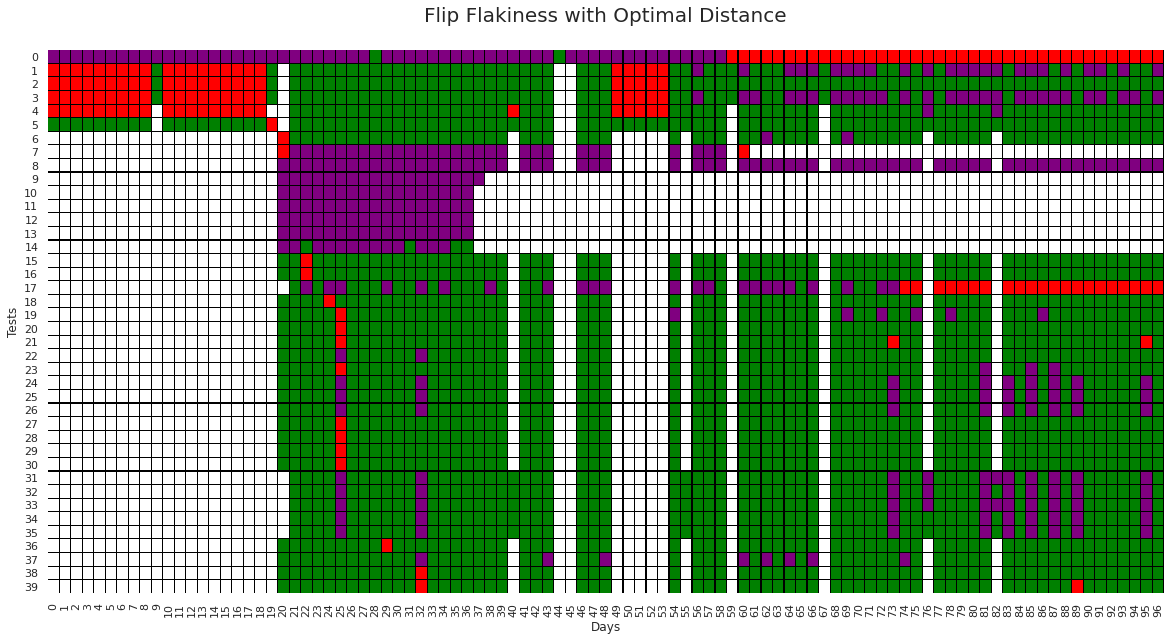

In [71]:
plt.figure(figsize=(20, 10))
cmap = colors.ListedColormap(["white", "green", "red", "purple"])
norm = colors.BoundaryNorm(boundaries=[0, 1, 12, 13], ncolors=3)
sns.heatmap(
    np.array(list(details["flip_flakiness_optimal"][:40].values)),
    fmt="",
    cmap=cmap,
    norm=norm,
    cbar=False,
    linewidths=0.1,
    linecolor="Black",
)
plt.ylabel("Tests")
plt.xlabel("Days")
plt.title("Flip Flakiness with Optimal Distance\n", fontsize=20)
plt.show()

Cells with purple color in the above graph are the labels given by the `flip flake with optimal distance algorithm`.

In the above figure, we can see that `flip flakiness with optimal distance` method is able to detect the flaky behavior in test number 4, 19, 22, 23, 24, 25, 34, 35, 37, which `naive flake algorithm` were failed to detect and test 4 and 23  which `flip flake algorithm` was failed to detect. Also, it correctly classified flaky tests for test cases 1, 3, 17.  

Given the above, its safe to conclude that `Flip flakiness with optimal distance` works better than `naive flakiness` and `flip flakiness` methods on both are example and real world data sets.

In [72]:
total_flip_flake__optimal_label = np.count_nonzero(
    np.array(list(details["flip_flakiness_optimal"][:40].values)) == 13
)
print(
    "Number of flake labels given by the `flip flake optimal distance` method:",
    total_flip_flake__optimal_label,
)
print(
    "Total flaky test detected by the `flip flake optimal distance method` is",
    round(total_flip_flake__optimal_label / total_existing_flake_label, 2),
    "times \nthe total flaky tests detected by the existing testgrid method ",
)

Number of flake labels given by the `flip flake optimal distance` method: 424
Total flaky test detected by the `flip flake optimal distance method` is 2.05 times 
the total flaky tests detected by the existing testgrid method 


## Conclusion


**TLDR: Flip Flakiness with Optimal Distance is best!**

In this notebook, we explored 3 different methods for automatically identifying flaky tests.

1) **Naive Flakiness**: This was our baseline method to compare the performance of the other two methods. This method simply calculates flakiness as a ratio of failed tests over total tests. As we expected, this method performed the worst and should not be used in the future for flake identification. 


2) **Flip Flakiness**: This method relied on counting the number of edges (flips from pass to fail) for a test. Although it performed much better than the naive method, it fell short for longer test examples with flaky regions in an otherwise stable time-series. Moving forward, this method should not be used either. 


3) **Flip Flakiness with Optimal Distance**: This method extended the flip flakiness method by identifying irregular subsets within a test. This was the best performing method explored in this notebook and should be carried forward into the [failure type classification](https://github.com/aicoe-aiops/ocp-ci-analysis/blob/master/notebooks/failure-type-classification/README.md) tool and serve as the new baseline.   



## Next Steps

* The current upstream [testgrid repo](https://github.com/GoogleCloudPlatform/testgrid) uses both `Naive flakiness` and `Flip flakiness`  methods for detecting flakes. We should open an issue and suggest including `Flip flakiness with optimal distance` into their workflow to further improve flake identification. 


* One limitation of the work in this notebook is that we only used the results of previous runs as our data to detect flaky tests. This is not the only data available to us. Next, we can try incorporating additional metadata (like git revisions or linked bugzillas) to improve upon our existing flake identification methods. See [this article](https://medium.com/fitbit-tech-blog/a-machine-learning-solution-for-detecting-and-mitigating-flaky-tests-c5626ca7e853) for possible avenues of future development.  